# Minimisation of functions with Enzyme on the IPU

Load the packages that we will use

In [1]:
using IPUToolkit.IPUCompiler, IPUToolkit.Poplar
using Enzyme
using Plots

Some settings:

In [2]:
ENV["POPLAR_RUNTIME_OPTIONS"] = """{"target.hostSyncTimeout":"60"}""";
IPUCompiler.KEEP_LLVM_FILES[] = true;

In [3]:
## Define some functions we'll use in our program
# Convenient method for computing the derivative of a 2-argument function `f` on points `x` and `y` with Enzyme
∂(f, x, y) = first(autodiff_deferred(Reverse, f, Active(x), Active(y)));
# The function we want to minimise
rosenbrock(x, y) = (1 - x) ^ 2 + 100 * (y - x ^ 2) ^ 2
# The derivative of the function we want to minimise,
# computed with Enzyme.
rosenbrock′(x, y) = ∂(rosenbrock, x, y)
# Minimise a function with Adam method and return the number of iterations
function adam(∂f, x₀::T, y₀::T) where {T}
    x, y = x₀, y₀
    # Some constants
    α = T(0.001) # learning rate
    β₁ = T(0.9)
    β₂ = T(0.999)
    ϵ = T(1e-8)
    # Momenta
    m = zero(T), zero(T)
    v = zero(T), zero(T)
    # Stopping criteria
    Δ = 10 * eps(T)
    δ_x, δ_y = one(T), one(T)
    max_t = Int32(500_000)
    t = one(max_t)
    while abs(δ_x) > Δ < abs(δ_y) && t ≤ max_t
        g = ∂f(x, y)
        m = β₁ .* m .+ (1 - β₂) .* g
        v = β₂ .* v .+ (1 - β₂) .* g .^ 2
        m̂ = m ./ (1 - β₁ ^ t)
        v̂ = v ./ (1 - β₂ ^ t)
        δ_x, δ_y = α .* m̂ ./ (.√(v̂) .+ ϵ)
        x -= δ_x
        y -= δ_y
        t += one(t)
    end
    # Subtract one because at the end of the last iteration we
    # added 1 to the counter but didn't run the following iteration.
    return t - one(t)
end

adam (generic function with 1 method)

Run the program:

In [4]:
# Obtain a device and initialise the graph and the program
device = Poplar.get_ipu_device()
target = Poplar.DeviceGetTarget(device)
graph = Poplar.Graph(target)
prog = Poplar.ProgramSequence()

# Number of total IPU tiles on the device
num_tiles = Int(Poplar.TargetGetNumTiles(target))

# Create grid of initial points
make_grid(x::T, y::T) where {T<:AbstractVector} =
    repeat(x; inner=length(y)), repeat(y; outer=length(x))

# High resolution range
x_range = y_range = collect(Float32.(range(-6; step=2^-4, length=23 * 8)))
# # Low resolution range
# x_range = collect(Float32.(range(-6; step=2^-2, length=23 * 2)))
# y_range = collect(Float32.(range(-8; step=2^-2, length=64)))
# Inputs to the codelet
x₀, y₀ = make_grid(x_range, y_range)
# Output of the codelet
num_iterations = similar(x₀, Int32)

# Compile the codelet in the graph
@codelet graph function RosenAdam(x::VertexVector{Float32, IPUCompiler.In},
                                  y::VertexVector{Float32, IPUCompiler.In},
                                  num_iterations::VertexVector{Int32, IPUCompiler.Out})
    for idx in eachindex(num_iterations)
        num_iterations[idx] = adam(rosenbrock′, x[idx], y[idx])
    end
end

# Create IPU arrays
x₀_ipu = Poplar.GraphAddConstant(graph, x₀)
y₀_ipu = Poplar.GraphAddConstant(graph, y₀)
num_iterations_ipu = similar(graph, num_iterations, Int32)

# Spread vertices across all tiles
add_vertex(graph, prog, 0:(num_tiles - 1), RosenAdam, x₀_ipu, y₀_ipu, num_iterations_ipu)

# Prepare for reading the output tensor
Poplar.GraphCreateHostRead(graph, "iterations-read", num_iterations_ipu)

# Run and time the program.  This will take about 30 seconds, be patient.
engine = Poplar.Engine(graph, prog)
elapsed = @elapsed Poplar.EngineLoadAndRun(engine, device)

# Copy the output tensor to the CPU into a Julia vector
Poplar.EngineReadTensor(engine, "iterations-read", num_iterations)

# Release the device
Poplar.detach_devices()

# Reshape the vector into a matrix
m = reshape(sqrt.(Int.(num_iterations)), length(y_range), length(x_range))

# Print out how long it took to run the program
@info "Loading and running the program minimising the Rosenbrock function on $(length(x₀)) points took $(round(elapsed; sigdigits=4)) seconds"

[ Info: Trying to attach to device 0...
[ Info: Successfully attached to device 0
✓ Compiling codelet RosenAdam: 	 Time: 0:00:20
[ Info: Loading and running the program minimising the Rosenbrock function on 33856 points took 28.54 seconds


In [5]:
# Always remember to release the device after use!
Poplar.detach_devices()

Plot the result:

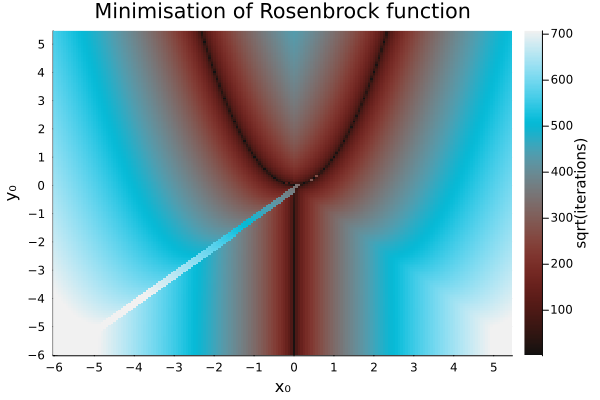

In [6]:
xticks = yticks = -20:1:20
heatmap(x_range, y_range, m;
        seriescolor = :linear_tritanopic_krjcw_5_95_c24_n256,
        xlabel = "x₀",
        ylabel = "y₀",
        xticks,
        yticks,
        colorbar_title = "sqrt(iterations)",
        title = "Minimisation of Rosenbrock function",
    )